In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Gradient Boosted Trees Classifier to Predict the Malignancy in Breast Epithelial Cells

Cell biopsies, in particular fine need aspirates (FNA), have been used in the past to identify cell malignancies. Here we trained a Gradient Boosted Trees Classifier to evaluate measurements from breast epithelial cells from FNA samples, and predict whether or not cells are malignant. As undoubtedly some measurements are easier to facilitate, we develope a series of simple 1-off rules to predict cell-malignancy in comparison to more advanced machine learning methods.

# Data Processing

We evaluated the [Wisconsin Breast Cancer Database](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)). This breast cancer databases was obtained from the University of Wisconsin Hospitals, Madison from Dr. William H. Wolberg. 

The features aggregated in this dataset contain:

1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)

### References

1. O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.
2. William H. Wolberg and O.L. Mangasarian: "Multisurface method of pattern separation for medical diagnosis applied to breast cytology", Proceedings of the National Academy of Sciences, U.S.A., Volume 87, December 1990, pp 9193-9196.
3. O. L. Mangasarian, R. Setiono, and W.H. Wolberg: "Pattern recognition via linear programming: Theory and application to medical diagnosis", in: "Large-scale numerical optimization", Thomas F. Coleman and YuyingLi, editors, SIAM Publications, Philadelphia 1990, pp 22-30.
4. K. P. Bennett & O. L. Mangasarian: "Robust linear programming discrimination of two linearly inseparable sets", Optimization Methodsand Software 1, 1992, 23-34 (Gordon & Breach Science Publishers).

### Download the dataset

In order to ensure reproducibility, we provide a method to automatically download the dataset, and process it as a `Pandas.DataFrame`. Please make sure that `Pandas`, `requests`, and `io` packages are installed on your local machine.

In [2]:
import requests
import io

# Download from URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
response = requests.get(url)

# Define feature/column names
col_names = ['id', 'clump_thickness', 'size_uniformity', 'shape_uniformity',
             'marg_adhesion', 'cell_size', 'nuclei', 'chromatin', 'nucleoli',
             'mitoses', 'class']

# Store as Pandas.DataFrame
data = pd.read_csv(io.StringIO(response.content.decode('utf-8')),
                   header=None, names=col_names, index_col=0)

### Rename class labels

The database uses the values `2` and `4` to label cells as "*Benign*" and "*Malignant*" respectively. This is not the most intuitive scheme, so we reassign them and convert our column to a `Pandas.Categorical` type.

In [166]:
data['class'] = pd.Categorical(data['class'].replace([2, 4], ['Benign', 'Malignant']))

### Impute missing data

In the nuclei column, there are 16 missing values. To impute the missing values, we simply evaluate the median and assign to all null entries. While we have evaluated the effect with and without imputation, we find that imputing with the median nuclei value gives a small improvement to predictive accuracy in our models.

In [167]:
data_dropna = data.replace('?', np.nan)
data_dropna = data_dropna.dropna()

data.loc[data['nuclei'] == '?', 'nuclei'] = data_dropna['nuclei'].median()
data['nuclei'] = data['nuclei'].astype(int)

Our cleaned dataframe has 9 features with a class label for cell malignancy.

In [170]:
data.head()

,clump_thickness,size_uniformity,shape_uniformity,marg_adhesion,cell_size,nuclei,chromatin,nucleoli,mitoses,class
id,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,Benign
1002945,5,4,4,5,7,10,3,2,1,Benign
1015425,3,1,1,1,2,2,3,1,1,Benign
1016277,6,8,8,1,3,4,3,7,1,Benign
1017023,4,1,1,3,2,1,3,1,1,Benign


We can also evaluate the distribution of our features

In [171]:
data.describe()

,clump_thickness,size_uniformity,shape_uniformity,marg_adhesion,cell_size,nuclei,chromatin,nucleoli,mitoses
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.486409,3.437768,2.866953,1.589413
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.621929,2.438364,3.053634,1.715078
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


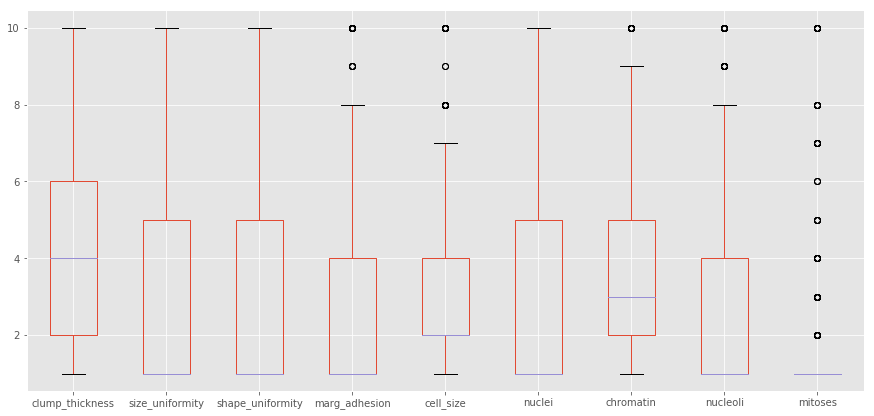

In [354]:
data.boxplot(figsize=(15, 7), showcaps=True)
plt.show()

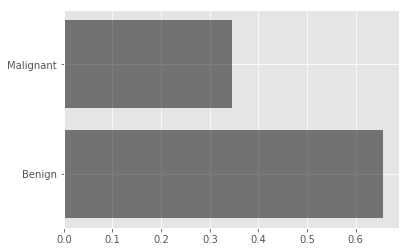

In [226]:
plt.barh(['Benign', 'Malignant'], data['class'].value_counts() / data['class'].count(), color='k', alpha=0.5)
plt.show()

# Methods

To evaluate cell malignancy we performed ensemble methods such as Random Forest and Gradient Boosted Classification. While many models could work, tree-based methods provide a metric for feature-importance. This will allow us to evaluate and recommend the best predictors for classification. Ideally, less features to track means less test strain on the patient, faster results, and reduced costs.

In [144]:
X = data[col_names[1:-1]].astype(int)
y = data['class']

# Random Forest

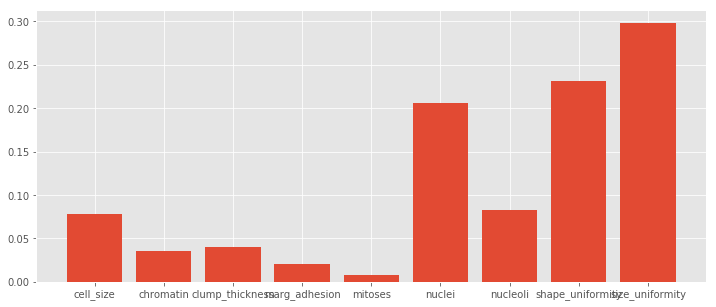

In [264]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X, y)

plt.figure(figsize=(12, 5))
plt.bar(X.columns, rf.feature_importances_)
plt.show()

# Gradient Boost

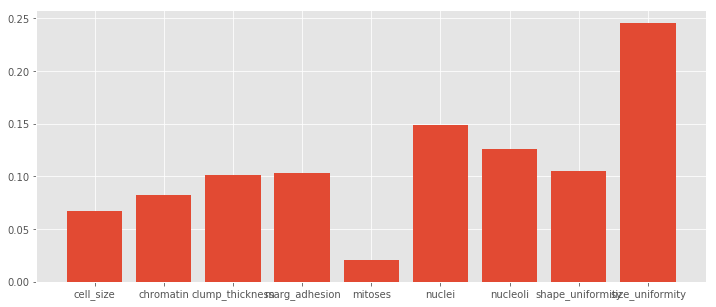

In [265]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier().fit(X, y)

plt.figure(figsize=(12, 5))
plt.bar(X.columns, gb.feature_importances_)
plt.show()

# Cross Validation

We performed 5-fold cross validation:

1. To evaluate the accuracy of the model
2. To evaluate the stability of the model

In [298]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import auc, roc_curve
from scipy import interp

### Random Forest

Accuracy per Fold
K-Fold 1: Accuracy = 0.9124, F1 = 0.8947
K-Fold 2: Accuracy = 0.9270, F1 = 0.9231
K-Fold 3: Accuracy = 0.9635, F1 = 0.9505
K-Fold 4: Accuracy = 0.9853, F1 = 0.9655
K-Fold 5: Accuracy = 0.9926, F1 = 0.9859



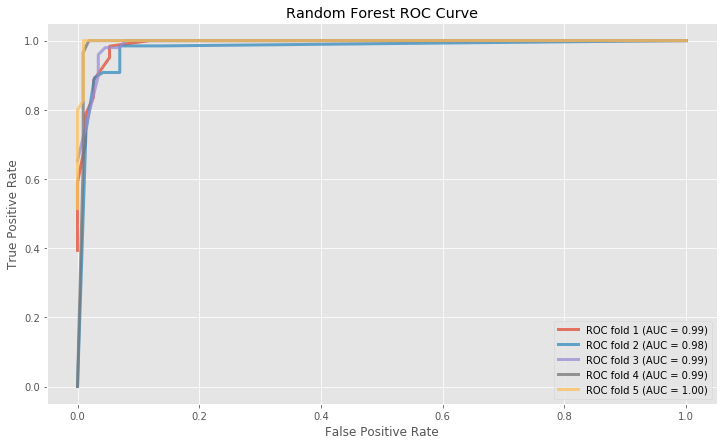

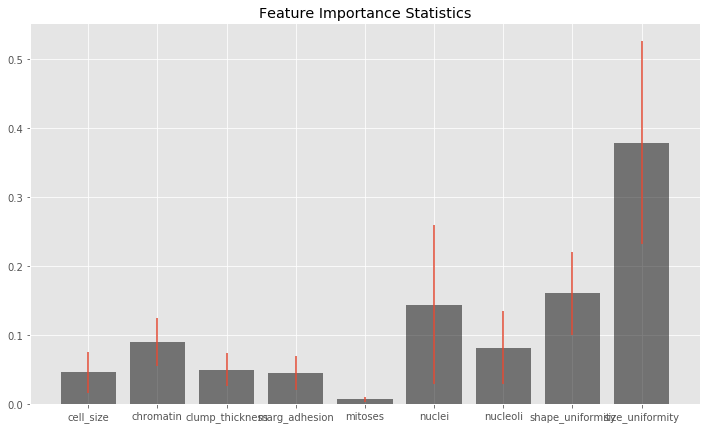

In [311]:
k = 1
n_folds = 5
n_features = len(col_names[1:-1])
rf_feature_importance = []

tpr_ = []
auc_ = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(12, 7))
kf = KFold(n_splits=n_folds, random_state=42, shuffle=False)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Model
    rf_tmp = RandomForestClassifier().fit(X_train, y_train)
    
    # ROC Curve
    p = rf_tmp.predict_proba(X_test)
    fpr, tpr, threshold = roc_curve(y_test.cat.codes, p[:, 1])
    tpr_.append(interp(mean_fpr, fpr, tpr))
    tpr_[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    auc_.append(roc_auc)
    
    plt.plot(fpr, tpr, lw=3, alpha=0.75,
             label='ROC fold %d (AUC = %0.2f)' % (k, roc_auc))

    # Print Accuracy
    acc = accuracy_score(y_test, rf_tmp.predict(X_test))
    f1 = f1_score(y_test, rf_tmp.predict(X_test), pos_label='Malignant')
    if k == 1:
        print("Accuracy per Fold")
    print("K-Fold {:d}: Accuracy = {:0.4f}, F1 = {:0.4f}".format(k, acc, f1))
    
    # Feature Importance
    rf_feature_importance.append(rf_tmp.feature_importances_)
    
    # Update index
    k += 1

print()
# Format ROC Curve
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
plt.show()
    
# Feature Importance Statistics
plt.figure(figsize=(12, 7))
plt.bar(col_names[1:-1], np.array(rf_feature_importance).mean(0), color='k', alpha=0.5)
plt.errorbar(col_names[1:-1], np.array(rf_feature_importance).mean(0), 
             yerr=np.array(rf_feature_importance).std(0),
             fmt=' ')
plt.title('Feature Importance Statistics')
plt.show()

### Gradient Boosting

Accuracy per Fold
K-Fold 1: Accuracy = 0.9270, F1 = 0.9153
K-Fold 2: Accuracy = 0.9489, F1 = 0.9466
K-Fold 3: Accuracy = 0.9562, F1 = 0.9400
K-Fold 4: Accuracy = 0.9853, F1 = 0.9655
K-Fold 5: Accuracy = 0.9853, F1 = 0.9714



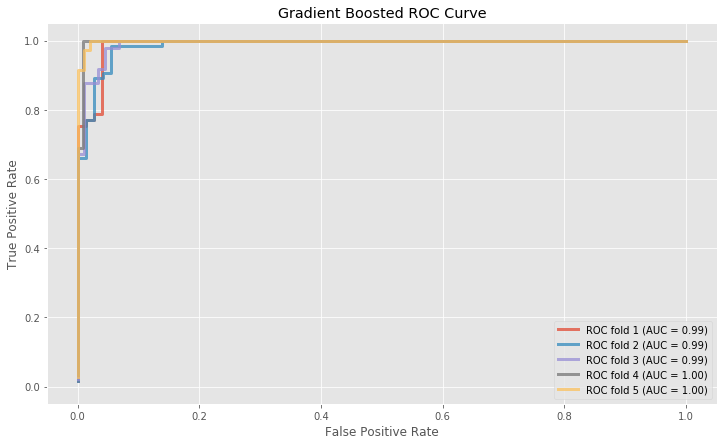

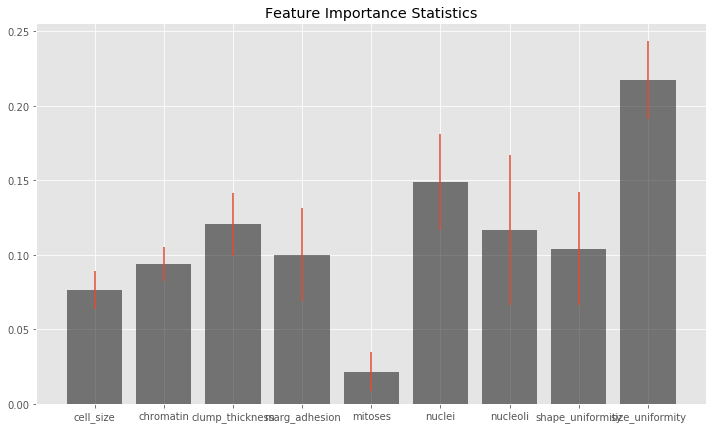

In [310]:
k = 1
n_folds = 5
n_features = len(col_names[1:-1])
gb_feature_importance = []

tpr_ = []
auc_ = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(12, 7))

kf = KFold(n_splits=n_folds, random_state=42, shuffle=False)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Model
    gb_tmp = GradientBoostingClassifier().fit(X_train, y_train)
    
    # ROC Curve
    p = gb_tmp.predict_proba(X_test)
    fpr, tpr, threshold = roc_curve(y_test.cat.codes, p[:, 1])
    tpr_.append(interp(mean_fpr, fpr, tpr))
    tpr_[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    auc_.append(roc_auc)
    
    plt.plot(fpr, tpr, lw=3, alpha=0.75,
             label='ROC fold %d (AUC = %0.2f)' % (k, roc_auc))

    ## Print Accuracy
    acc = accuracy_score(y_test, gb_tmp.predict(X_test))
    f1 = f1_score(y_test, gb_tmp.predict(X_test), pos_label='Malignant')
    if k == 1:
        print("Accuracy per Fold")
    print("K-Fold {:d}: Accuracy = {:0.4f}, F1 = {:0.4f}".format(k, acc, f1))
    
    # Feature Importance
    gb_feature_importance.append(gb_tmp.feature_importances_)
    
    # Update index
    k += 1

print()
# Format ROC Curve
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosted ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Feature Importance Statistics
plt.figure(figsize=(12, 7))
plt.bar(col_names[1:-1], np.array(gb_feature_importance).mean(0), color='k', alpha=0.5)
plt.errorbar(col_names[1:-1], np.array(gb_feature_importance).mean(0), 
             yerr=np.array(gb_feature_importance).std(0),
             fmt=' ', )
plt.title('Feature Importance Statistics')
plt.show()

# Selecting the Gradient Boosted Model

Ultimately, the predictive capabailities of the Random Forest vs Gradient Boosted classifiers was not significantly different. We can see that both have great accuracy as indicated by the cross-validation in all folds. Additionally, all folds have a high $F_1$ value indicating our models have good precision **and** recall. While the Gradient Boosted classifier has slightly higher AUROC across all folds, this is a very small decision.

The determining factor however is the variability in the feature importance. Ultimately, the goal is to be able to select the important predictors for cancer screens, and to perform that we need a model which is insensitive to training data. Clearly in the case of Random Forests, the estimated feature-importance varies significantly from the training set. This is not as substantial in the Gradient Boosted classifier, and therefore we'll select that as our model.

# Evaluating Partial Dependence on Features

These models have shown great accuracy, but aside from discarding data, we want to evaluate how to reduce necessary tests. This places less stress on the patient, reduces wait time, and can potentially save significant costs. While feature importance is significant in selecting the best features, we also want to find what dependence each feature has on prediction.

Using partial-dependence, we can evaluate the regression from our model in the absense of all other features. This let's us see at what values, per feature, can we predict malignancy in cells. 

In [72]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

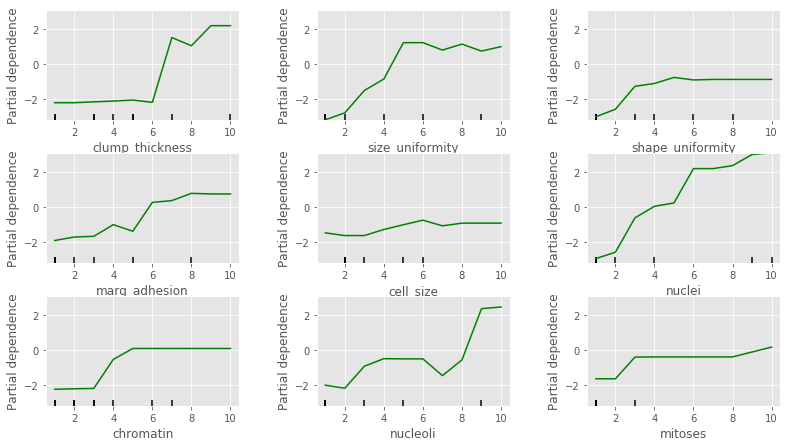

In [173]:
plot_partial_dependence(gb, X, range(len(X.columns)),
                        feature_names=X.columns,
                        n_jobs=4, grid_resolution=50, figsize=(12, 10))
plt.show()

# Selecting Significant Features

From only two features, (size and shape uniformity), we can identify malignancy with 94% accuracy. The dataset is rich enough that we can accurately the model from many different models.

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [127]:
X.columns[[1,2]]

Index(['size_uniformity', 'shape_uniformity'], dtype='object')

In [130]:
X_sub = data.iloc[:, [1,2]]
X_sub.loc[:,'Cross'] = X_sub.iloc[:,0] * X_sub.iloc[:,1]

lm = LogisticRegression()
scores = cross_val_score(lm, X_sub, y, scoring='accuracy', cv=5)
print(scores.mean())
lm.fit(X_sub,y)

0.94300081103


/Users/pablo/.conda/envs/Insight/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/pablo/.conda/envs/Insight/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Selecting Screening Rules

In a clinical setting a simple 1-off rule (or "*back of the envelope* calculation) can be far more efficient, therefore we evaluated the partial dependences to determine a 1, 2, and 3 feature prediction scheme from simple cutoffs.

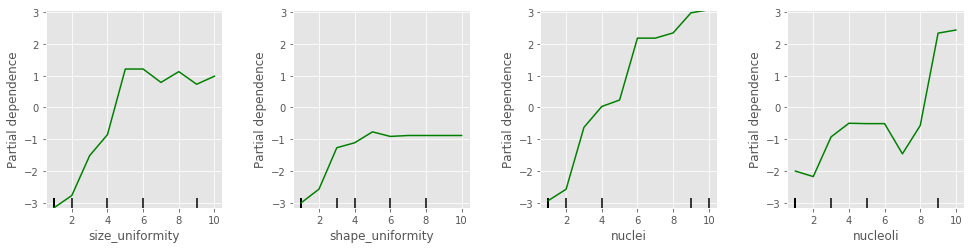

In [338]:
my_plots = plot_partial_dependence(gb, features=[1, 2, 5, 7], X=X, feature_names=X.columns, 
                                   n_cols=4, grid_resolution=50, figsize=(15, 5),)
plt.show()

### 1-Feature Rule

In [134]:
yhat = pd.Series(0, index=X.index)
yhat[X['size_uniformity'] >= 4] = 1
(yhat == y.cat.codes).sum() / float(len(y))

0.92972181551976574

In [340]:
yhat = pd.Series(0, index=X.index)
yhat[X['shape_uniformity'] >= 4] = 1
(yhat == y.cat.codes).sum() / float(len(y))

0.92532942898975112

### 2-Feature Rule

In [342]:
yhat = pd.Series(0, index=X.index)
yhat[X['size_uniformity'] >= 4] = 1
yhat[X['shape_uniformity'] >= 4] = 1
(yhat == y.cat.codes).sum() / float(len(y))

0.94436310395314793

In [353]:
yhat = pd.Series(0, index=X.index)
yhat[X['nuclei'] >= 4] = 1
yhat[X['nucleoli'] >= 7] = 1
(yhat == y.cat.codes).sum() / float(len(y))

0.93704245973645683

### 3-Feature Rule

In [163]:
yhat = pd.Series(0, index=X.index)
yhat[X['size_uniformity'] >= 4] = 1
yhat[X['nuclei'] > 5] = 1
yhat[X['nucleoli'] >= 9] = 1
(yhat == y.cat.codes).sum() / float(len(y))

0.96632503660322111

# Conclusions

A variety of machine learning algorithms were able to accurately predict cell malignancy as validated by accuracy, $F_1$ scores, and AUROC. While we saw that Gradient Boosted classifiers outperformed Random Forests and Logistic Regression, ultimately the improvement was very small. The selection of the Gradient Boosted classifier came largely down to it's stability in feature-importance, as shown with K-Folds cross validation, was lacking in random forests.

A more significant results was that from single features, cell malignancy can be predicted with >90% accuracy. This insight suggests that individual features may be sufficient for preliminary screenings. Further, the use of simple, partial-dependence cutoff-metrics per feature resulted in >90% accuracy. The change in accuracy between the 1, 2, and 3 feature-rules were small and ultimately some features were better predictors as a 1-feature rule than some combinations of 3 features. 

If further information were available on the cost, speed, and invasiveness of performing the test per feature, this study could be used as the groundwork to create a "*back of the envelope*" test for clinical settings. Lab practicioners could simple evaluate the simplest feature which would give a quick, preliminary result to the patient, reduce potential invasive procedures, and reduce the necessary costs to measure all reported features.